In [3]:
#import required packages and projection of data onto TICs
import pyemma
import numpy as np
import matplotlib.pyplot as plt
import deeptime
from tqdm.notebook import tqdm
import os
import mdtraj as md


In [5]:
wd = os.getcwd()+"/"
p = np.load(wd+"ntxd/dist_sa_tics_lag30.npy")
p_red = p[:,:2]

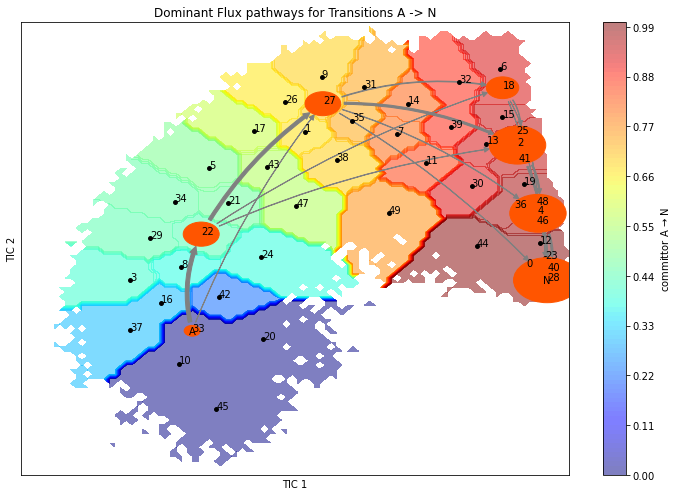

In [22]:
#Estimate MSM, PCCA, determine dominant pathways


path_frames_og = np.load(wd+"ntxd/path_frames.npy")
#get old clustercenter frames,ect
dtraj = np.load(wd+"ntxd/dist_sa_dtraj.npy")
clustercenters_ = np.load(wd+"ntxd/dist_sa_clcenters.npy")
clustercenters_red = clustercenters_[:,:2]
frames_cl_ = []
for i in range(7):
    frames = np.where(dtraj==i)[0]
    frames_cl_.append(frames)

center_frames_ = []
for i in range(len(frames_cl_)):
    s = frames_cl_[i][np.argmin(np.sum((p_red[frames_cl_[i]]-clustercenters_red[i])**2,axis=1))]
    center_frames_.append(s)

#kmeans cluster with deeptime
from deeptime.clustering import KMeans
cluster = KMeans(50, max_iter=500, progress=tqdm)\
    .fit_fetch(p[:,:2])

#get discrete trajectory
dtrajs = cluster.transform(p[:,:2])
clustercenters = cluster.cluster_centers
frames_cl =[]
for i in range(200):
    frames = np.where(dtrajs==i)[0]
    frames_cl.append(frames)

#estimate implied timescales from dicrete trajectory (the function is estimating many MSMs as various lagtimes, "under the hood")
its = pyemma.msm.its(dtrajs, lags=[*range(0,500,5)])
plt.figure()
pyemma.plots.plot_implied_timescales(its, ylog=True)


#estimate MSM based on its and previous knowlegde that the transitions of interest are FAST
lag=51
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import MaximumLikelihoodMSM
counts_estimator = TransitionCountEstimator(lag, "sliding")
counts = counts_estimator.fit_fetch(dtrajs)
counts = counts.submodel_largest()
msm_estimator = MaximumLikelihoodMSM()
msm=msm_estimator.fit_fetch(counts)
#return eigenvectors of transition matrix from MSM
eigvec = msm.eigenvectors_right()
#coarse grain into 7 states in hopes that we recover the familiar states from previous models
from deeptime.markov import pcca
nstates = 7
pcca = pcca(msm.transition_matrix, nstates)
#derive new traj descriptions based on course grained MSM result
metastable_traj = pcca.assignments[dtrajs]
highest_membership = pcca.metastable_distributions.argmax(1)
coarse_state_centers = cluster.cluster_centers[msm.count_model.state_symbols[highest_membership]]


#visualize eigenvectors..e.i see what processes are occuring and between which states
fig, ax = plt.subplots(3, 3, figsize=(20, 15))
fig.delaxes(ax[2][1])
fig.delaxes(ax[2][2])
for i, ax in enumerate(ax.flat[:-2]):
    pyemma.plots.plot_contour(
        *p[:,:2].T, eigvec[dtrajs, i + 1], ax=ax, cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*clustercenters[:,:2].T, s=15, c='C1')
    ax.set_xlabel('TIC 1')
    ax.set_ylabel('TIC 2')
    ax.set_title(f"Right Eigen Vector for Metastable State {i+1}")
    ax.scatter(*p_red[center_frames_].T,c="black",s=50)
    for j,c in enumerate(center_frames_):
        ax.annotate(text=f"{j}",xy=(p_red[c]),size=30)  
fig.tight_layout()
#visualize the probability distribution for each metastable state
fig, ax = plt.subplots(3, 3, figsize=(20, 15))
for i, ax in enumerate(ax.flat[:-2]):
    pyemma.plots.plot_contour(
        *p[:,:2].T,
        pcca.metastable_distributions[i][dtrajs],
        ax=ax,
        cmap='PiYG', 
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('TIC 1')
    ax.set_ylabel('TIC 2')
    ax.scatter(*clustercenters_red.T,c="black",s=50)
    ax.set_title(f"Prob Distribution for Metastable State {i+1}")
    for j,c in enumerate(clustercenters_red):
        ax.annotate(text=f"{j+1}",xy=(c),size=30)
    ax.scatter(*clustercenters[:,:2].T, s=15, c='C1')
fig.tight_layout()

#calculate mean first passage times
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            pcca.sets[i],
            pcca.sets[j])

from pandas import DataFrame
print('MFPT / steps:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))


# #determine reactive flux between unfolded and most native state
# from deeptime.markov import reactive_flux

A = pcca.sets[0]
B = pcca.sets[6]
flux = reactive_flux(msm.transition_matrix, A, B)


#determine coarse flux and dominant pathways
cg, cgflux = flux.coarse_grain(pcca.sets)
paths = cgflux.pathways()

#plot dominant pathways (those with highest flux) along with the committor between the states of interest
fig, ax = plt.subplots(1,1,figsize=(10, 7))

pyemma.plots.plot_contour(
    *p[:,:2].T,
    flux.forward_committor[dtrajs],
    cmap='jet',
    ax=ax,
    alpha=.5,
    mask=True,
    cbar_label=r'committor A $\to$ N',
    zorder=-1);

pyemma.plots.plot_flux(
    cgflux,
    coarse_state_centers,
    state_scale = 1,
    state_labels=['A',"","","","","",'N'], 
    ax=ax,
    arrow_curvature=1,
    alpha=1,
    show_committor=False,
    figpadding=0,
    show_frame=True,
    minflux=2.5960269780289e-05,
    arrow_label_format='');


plt.scatter(*clustercenters[:,:2].T, s = 15, c="k")
for i in range(50):
    plt.annotate(text="{}".format(str(i)),xy=(clustercenters[i]),size=10,)

ax.set_xlabel("TIC 1")
ax.set_ylabel("TIC 2")
ax.set_xlim(p_red[:,0].min(),p_red[:,0].max())
ax.set_ylim(p_red[:,1].min(),p_red[:,1].max())
ax.set_title("Dominant Flux pathways for Transitions A -> N")
fig.tight_layout()


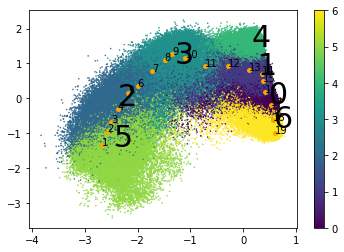

In [151]:
#plot path_frames on cluster map
plt.scatter(*p_red.T,c=dtraj,s=.3)
plt.colorbar()
plt.scatter(*p_red[path_frames_og].T, s = 15, c="orange")
plt.xlabel("TIC1")
plt.ylabel("TIC2")
plt.title("State map with path frames from clusters")

for i in range(len(path_frames_og)):
    plt.annotate(text="{}".format(str(i+1)),xy=(p_red[path_frames_og[i]]),size=10,)
for i,j in enumerate(clustercenters_red):
    plt.annotate(text="{}".format(str(i)),xy=(j),size=30,color="black")


In [166]:
clx = [[5,2],[5,2],[5,2],[5,2,3],[5,2,3],[2,3],[2,3],[3],[3],[3,1],[3,1],[1],[1],[1,0],[1,0],[1,0],[0,6],[0,6]]

In [167]:
##additional linear mapping to generate more frames for the guess path,
#connecting frames between cluster centers of guess path.


#define a function to identify additional frames between clustercenter based path frames
def inc(x1,x2,dt,frames,p_red):
    d = x2-x1
    d_ = np.sqrt(np.sum(d**2))
    n=d_/dt
    t = d/n
    pt = []
    v = np.zeros(2).flatten()
    for i in range(int(np.floor(n))):
        v = x1+t*i
        pt.append(v)
    #path_frames = [] --> define outside function
    xi = [np.array(p_red[i]) for i in frames]
    for i in pt:
        dj = frames[np.argsort(np.array([np.sqrt(np.sum((i-x)**2)) for x in xi]))].tolist()
        for j in dj:
            if not j in path_frames:
                path_frames.append(j)
                break
    
    return path_frames
        
    
    

In [168]:
path_frames = [] #need this to loop incremental function
for cl_idx,i in zip(clx,range(len(path_frames_og)-1)):
    x1 = p_red[path_frames_og[i]]
    x2 = p_red[path_frames_og[i+1]]
    frames = np.hstack([frames_cl_[k] for k in cl_idx])
    nf = inc(x1,x2,.01,frames,p_red)

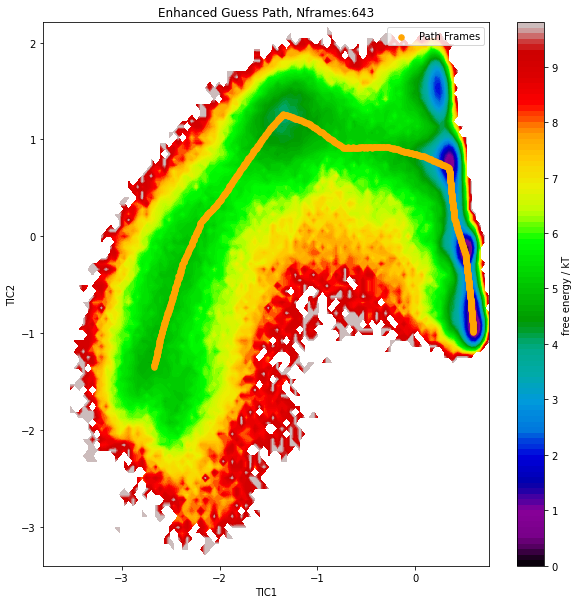

In [10]:
path_frames = np.load(os.getcwd()+"/"+"ntxd/enhanced_path_frames.npy")
fig,ax=plt.subplots(1,1,figsize=(10,10))
pyemma.plots.plot_free_energy(*p_red.T,ax=ax)
ax.scatter(*p_red[np.array(path_frames)].T,s=30,color="orange",label="Path Frames",marker="o")
ax.set_xlabel("TIC1")
ax.set_ylabel("TIC2")
ax.set_title(f"Enhanced Guess Path, Nframes:{len(path_frames)}")
plt.legend()

In [172]:
# np.save("/home/t/chem101/pcv/marvel-2/enhanced_path_frames",np.array(path_frames))
# pdb = '/home/t/IDP_MSM/strucs/Ntail.XD.protein.pdb'
# trajectory = '/home/t/IDP_MSM/NtailXD_Data/traj_trunc.dcd'
# trj = md.load(trajectory,top=pdb)
# trj[np.array(path_frames)].save_dcd("/home/t/chem101/pcv/marvel-2/enhanced_path_frames.dcd")